In [1]:
DATASET_NAME = "4.LUNGS2_INSPECT"

In [2]:
# Import libraries

import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
import numpy as np
from skimage.transform import resize
import time
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import callbacks
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from keras.models import load_model
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import models as M
import losses as l

ROOT_DIR = os.path.abspath("./")
LOG_PATH = os.path.join(ROOT_DIR, "logs")
TARGET_PATH = os.path.join(LOG_PATH, "{}".format(DATASET_NAME))
print(os.listdir(TARGET_PATH))

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
['LUNGS2_HPF_Unet_jacard.txt', 'CT_oversegment_1.pdf', 'CT_jgraph.pdf', 'CT_artifact.pdf', 'CT_noise.pdf', 'LUNGS2_Unet_jac_graph.pdf', 'CT_mislabelled.pdf', 'LUNGS2_Unet_jacard.txt', 'CT_oversegment_3.pdf', 'LUNGS2_Unet.h5', 'CT_oversegment_2.pdf', 'LUNGS2_HPF_Unet.h5', 'LUNGS2_HPF_Unet_predicted_masks.npy', 'LUNGS2_HPF_Unet_masks.npy', 'LUNGS2_HPF_Unet_inputs.npy', 'LUNGS2_Unet_REPORT.txt', 'LUNGS2_HPF_Unet_loss_graph.pdf', 'LUNGS2_Unet_inputs.npy', 'images', 'LUNGS2_Unet_masks.npy', 'LUNGS2_HPF_Unet_jac_graph.pdf', 'oversegment', 'LUNGS2_Unet_predicted_masks.npy', 'LUNGS2_HPF_Unet_REPORT.txt', 'CT_roc.pdf', 'LUNGS2_Unet_loss.txt', 'LUNGS2_HPF_Unet_loss.txt', 'CT_lgraph.pdf', 'LUNGS2_Unet_loss_graph.pdf']


In [3]:
# Save images here
try:
    # directory to create
    os.mkdir(os.path.join(TARGET_PATH, "images"))
except FileExistsError:
    # directory already exists
    pass

imgs_path = os.path.join(TARGET_PATH, "images")
imgs_path

'/home/hasib/DeterministicU-Net/logs/4.LUNGS2_INSPECT/images'

In [4]:
def read_txt(path, loss):
    
    data = []
    with open(path, 'r') as f:
        for line in f:
            
            if loss != True:
                line = float(line[:4]) * 10
            else:
                line = float(line[:4]) / 10
            
            data.append(line)
        f.close()
    
    return data

### Cross validation best fold plotted

In [5]:
# Read Jaccard and Loss
ujp = read_txt(os.path.join(TARGET_PATH, "LUNGS2_Unet_jacard.txt"), loss=False)
ulp = read_txt(os.path.join(TARGET_PATH, "LUNGS2_Unet_loss.txt"), loss=True)
gjp = read_txt(os.path.join(TARGET_PATH, "LUNGS2_HPF_Unet_jacard.txt"), loss=False)
glp = read_txt(os.path.join(TARGET_PATH, "LUNGS2_HPF_Unet_loss.txt"), loss=True)

len(ujp), len(ulp), len(gjp), len(glp)

(122, 122, 49, 49)

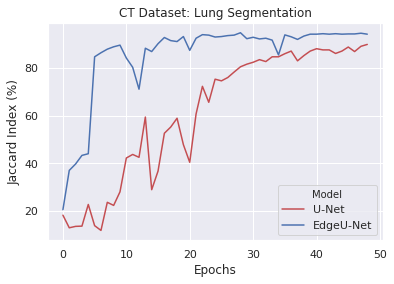

In [6]:
interval = min(len(ujp), len(gjp))
epochs = range(interval)
plt.plot(epochs, ujp[:interval], 'r')
plt.plot(epochs, gjp[:interval], 'b')

plt.title('CT Dataset: Lung Segmentation')
plt.ylabel('Jaccard Index (%)')
plt.xlabel('Epochs')
plt.legend(['U-Net', 'EdgeU-Net'], title="Model", loc='lower right')
plt.savefig('{}/CT_jgraph.pdf'.format(TARGET_PATH), dpi=100)

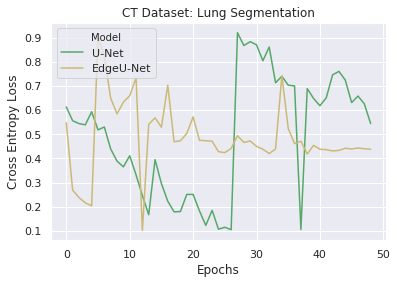

In [7]:
interval = min(len(ulp), len(glp))
epochs = range(interval)
plt.plot(epochs, ulp[:interval], 'g')
plt.plot(epochs, glp[:interval], 'y')

plt.title('CT Dataset: Lung Segmentation')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['U-Net', 'EdgeU-Net'], title="Model", loc='upper left')
plt.savefig('{}/CT_lgraph.pdf'.format(TARGET_PATH), dpi=100)

In [8]:
TARGET_PATH

'/home/hasib/DeterministicU-Net/logs/4.LUNGS2_INSPECT'

In [9]:
# Load Input images and gt masks from Unet
images = np.load("{}/LUNGS2_Unet_inputs.npy".format(TARGET_PATH))
masks = np.load("{}/LUNGS2_Unet_masks.npy".format(TARGET_PATH))
p1 = np.load("{}/LUNGS2_Unet_predicted_masks.npy".format(TARGET_PATH))
p2 = np.load("{}/LUNGS2_HPF_Unet_predicted_masks.npy".format(TARGET_PATH))

images.shape, masks.shape, p1.shape, p2.shape

((54, 256, 256, 1), (54, 256, 256, 1), (54, 256, 256, 1), (54, 256, 256, 1))

In [10]:
# Load unet predictions
#u_preds = np.load("{}/LUNGS2_Unet_predicted_masks.npy".format(TARGET_PATH))
#u_preds.shape
# Load Gauss Unet model
#model = None
#model = load_model("{}/LUNGS2_Gauss_Unet.h5".format(TARGET_PATH), compile=False)
#model.summary()
# Gauss Unet predictions
#preds = model.predict(x=images, verbose=1)
#preds = np.round(preds,0)
#preds.shape

In [11]:
def compute_jac(y, yhat):
    intersection = yhat.ravel() * y.ravel()
    union = yhat.ravel() + y.ravel() - intersection
    jacard = (np.sum(intersection)/np.sum(union))
    return jacard

In [12]:
# Check
#compute_jac(masks[0], masks[0])

In [13]:
from skimage.segmentation import mark_boundaries, find_boundaries

In [14]:
a = images[0].squeeze()
gt = masks[0]
x1 = p1[0]
x2 = p2[0]

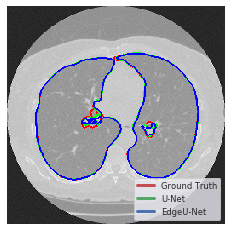

In [15]:
# Plot boundary on image

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([3], [3], color='r', lw=3, label='Ground Truth'),
                   Line2D([0], [0], color='g', lw=3, label='U-Net'),
                   Line2D([0], [0], color='b', lw=3, label='EdgeU-Net')
                  ]
                  
ct = 5
edges_pz = mark_boundaries(a, gt.squeeze().astype(np.int),color=(1,0,0), mode='thin') # gt
edges_pz = mark_boundaries(edges_pz, x1.squeeze().astype(np.int),color=(0,1,0), mode='thin') # unet
edges_pz = mark_boundaries(edges_pz, x2.squeeze().astype(np.int),color=(0,0,1), mode='thin') # det unet
plt.grid(False)
plt.axis('off')
plt.legend(handles=legend_elements, loc='lower right', fontsize='small')
plt.imshow(edges_pz)
plt.savefig("{}/test.png".format(imgs_path), pad_inches=0, bbox_inches='tight', dpi=100)

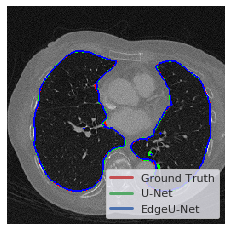

In [16]:
ct = 0

# Save images with contours
for idx in range(len(images)):
    a = images[idx].squeeze()
    gt = masks[idx]
    x1 = p1[idx]
    x2 = p2[idx]
    
    # Plot boundary on image
    legend_elements = [Line2D([3], [3], color='r', lw=3, label='Ground Truth'),
                       Line2D([0], [0], color='g', lw=3, label='U-Net'),
                       Line2D([0], [0], color='b', lw=3, label='EdgeU-Net')
                      ]
    
    edges_pz = mark_boundaries(a, gt.squeeze().astype(np.int),color=(1,0,0), mode='thin') # gt
    edges_pz = mark_boundaries(edges_pz, x1.squeeze().astype(np.int),color=(0,1,0), mode='thin') # unet
    edges_pz = mark_boundaries(edges_pz, x2.squeeze().astype(np.int),color=(0,0,1), mode='thin') # det unet
    plt.grid(False)
    plt.axis('off')
    plt.legend(handles=legend_elements, loc='lower right')
    plt.imshow(edges_pz)
    plt.savefig("{}/out_{}.png".format(imgs_path, ct), pad_inches=0, bbox_inches='tight', dpi=100)
    ct+=1

In [17]:
u_preds = p1
preds = p2

In [ ]:

# Plot images masks and contours
for i in range(len(images)):
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,5,1)
    if len(images[i].shape) >= 2:
        plt.grid(False)
        plt.axis('off')
        plt.imshow(images[i].squeeze(), cmap='gray') # 1-channel image
    else:
        plt.grid(False)
        plt.axis('off')
        plt.imshow(images[i]) # 3-channel
        
    plt.title('Input Image: {}'.format(i), y=-0.15)
    plt.subplot(1,5,2)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(masks[i].reshape(masks[i].shape[0],masks[i].shape[1]), cmap='magma')
    plt.title('Ground Truth', y=-0.15)
    
    plt.subplot(1,5,3)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(u_preds[i].reshape(u_preds[i].shape[0],u_preds[i].shape[1]), cmap='magma')
    
    jac = compute_jac(masks[i], u_preds[i])
    plt.title('U-Net ({0:.4f})'.format(jac), y=-0.15)
    
    plt.subplot(1,5,4)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(preds[i].reshape(preds[i].shape[0],preds[i].shape[1]), cmap='magma')
    
    jac = compute_jac(masks[i], preds[i])
    plt.title('EdgeU-Net ({0:.4f})'.format(jac), y=-0.15)
    
    # Plot boundary on image
    legend_elements = [Line2D([3], [3], color='r', lw=3, label='Ground Truth'),
                       Line2D([0], [0], color='g', lw=3, label='U-Net'),
                       Line2D([0], [0], color='b', lw=3, label='EdgeU-Net')
                      ]

    ct = 5
    edges_pz = mark_boundaries(images[i].squeeze(), masks[i].squeeze().astype(np.int),color=(1,0,0), mode='thin') # gt
    edges_pz = mark_boundaries(edges_pz, u_preds[i].squeeze().astype(np.int),color=(0,1,0), mode='thin') # unet
    edges_pz = mark_boundaries(edges_pz, preds[i].squeeze().astype(np.int),color=(0,0,1), mode='thin') # det unet
    plt.subplot(1,5,5)
    plt.grid(False)
    plt.axis('off')
    plt.legend(handles=legend_elements, loc='lower right', fontsize='small')
    plt.title('Comparison', y=-0.15)
    plt.imshow(edges_pz)
    #plt.savefig("{}/test.png".format(imgs_path), pad_inches=0, bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

In [19]:
def plot(i, legend_pos, name):
    plt.figure(figsize=(26,14))
    plt.subplot(1,5,1)
    if len(images[i].shape) >= 2:
        plt.grid(False)
        plt.axis('off')
        plt.imshow(images[i].squeeze(), cmap='gray') # 1-channel image
    else:
        plt.grid(False)
        plt.axis('off')
        plt.imshow(images[i]) # 3-channel

    plt.title('a) Input Image', y=-0.15)
    plt.subplot(1,5,2)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(masks[i].reshape(masks[i].shape[0],masks[i].shape[1]), cmap='magma')
    plt.title('b) Ground Truth', y=-0.15)

    plt.subplot(1,5,3)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(u_preds[i].reshape(u_preds[i].shape[0],u_preds[i].shape[1]), cmap='magma')

    jac = compute_jac(masks[i], u_preds[i])
    plt.title('c) U-Net ({0:.4f})'.format(jac), y=-0.15)

    plt.subplot(1,5,4)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(preds[i].reshape(preds[i].shape[0],preds[i].shape[1]), cmap='magma')

    jac = compute_jac(masks[i], preds[i])
    plt.title('d) EdgeU-Net ({0:.4f})'.format(jac), y=-0.15)

    # Plot boundary on image
    legend_elements = [Line2D([3], [3], color='r', lw=3, label='Ground Truth'),
                       Line2D([0], [0], color='g', lw=3, label='U-Net'),
                       Line2D([0], [0], color='b', lw=3, label='EdgeU-Net')
                      ]

    ct = 5
    edges_pz = mark_boundaries(images[i].squeeze(), masks[i].squeeze().astype(np.int),color=(1,0,0), mode='thin') # gt
    edges_pz = mark_boundaries(edges_pz, u_preds[i].squeeze().astype(np.int),color=(0,1,0), mode='thin') # unet
    edges_pz = mark_boundaries(edges_pz, preds[i].squeeze().astype(np.int),color=(0,0,1), mode='thin') # det unet
    plt.subplot(1,5,5)
    plt.grid(False)
    plt.axis('off')

    legend_pos = legend_pos

    plt.legend(handles=legend_elements, loc=legend_pos, fontsize='small')
    plt.title('Comparison', y=-0.15)
    plt.imshow(edges_pz)

    plt.savefig('{}/{}.pdf'.format(TARGET_PATH, name), bbox_inches='tight', pad_inches=0, dpi=100)
    plt.show()
    plt.close()

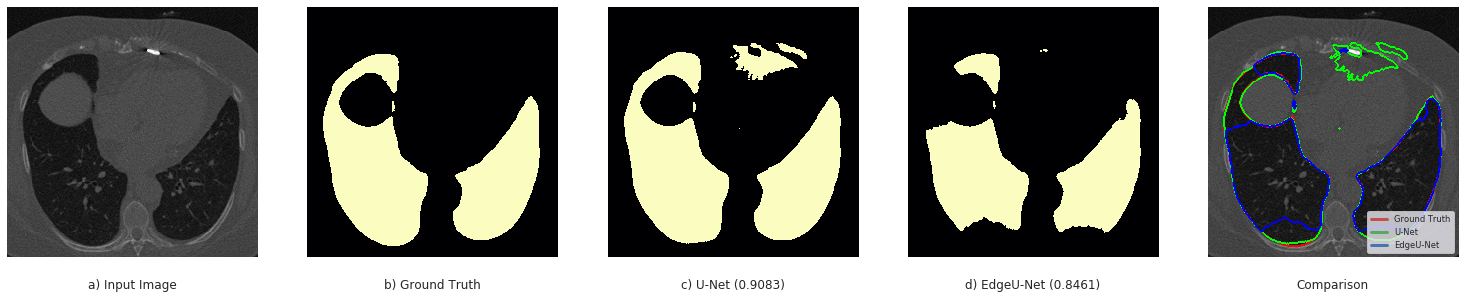

In [24]:
i = 52 # 14, 33, 35, 51, 52
name = "CT_3"
plot(i, 'lower right', name)

In [ ]:
u_preds = p1
preds = p2

masks.shape, u_preds.shape, preds.shape

In [ ]:
y_true = masks.ravel() 
y_1 = u_preds.ravel() 
y_2 = preds.ravel() 

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [ ]:
def get_res(y, yhat):
    
    fpr, tpr, thresholds = roc_curve((y), yhat)
    AUC_ROC = roc_auc_score(y, yhat)
    
    y_scores= yhat
    y_true = y 
    
    #Confusion matrix
    threshold_confusion = 0.5
    #print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
    y_pred = np.empty((y_scores.shape[0]))
    for i in range(y_scores.shape[0]):
        if y_scores[i]>=threshold_confusion:
            y_pred[i]=1
        else:
            y_pred[i]=0
    confusion = confusion_matrix(y_true, y_pred)
    #print (confusion)
    accuracy = 0
    if float(np.sum(confusion))!=0:
        accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
    #print ("Global Accuracy: " +str(accuracy))
    specificity = 0
    if float(confusion[0,0]+confusion[0,1])!=0:
        specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
    #print ("Specificity: " +str(specificity))
    sensitivity = 0
    if float(confusion[1,1]+confusion[1,0])!=0:
        sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
    #print ("Sensitivity: " +str(sensitivity))
    precision = 0
    if float(confusion[1,1]+confusion[0,1])!=0:
        precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
    #print ("Precision: " +str(precision))
    

    #F1 score
    F1_score = f1_score(y_true, y_scores, labels=None, average='binary', sample_weight=None)
    #print ("\nF1 score (F-measure): " +str(F1_score))
    
    return round(F1_score, 4), round(sensitivity, 4), round(specificity, 4), round(accuracy, 4), round(AUC_ROC, 4)
    

In [ ]:
# Unet
F1_score, sensitivity, specificity, accuracy, AUC_ROC = get_res(y_true, y_1)
print(F1_score, sensitivity, specificity, accuracy, AUC_ROC)

In [ ]:
# Deterministic U-Net
F1_score, sensitivity, specificity, accuracy, AUC_ROC = get_res(y_true, y_2)
print(F1_score, sensitivity, specificity, accuracy, AUC_ROC)

In [ ]:
#Area under the ROC curve
fpr1, tpr1, thresholds1 = roc_curve((y_true), y_1)
AUC_ROC1 = roc_auc_score(y_true, y_1)
print ("Area under the ROC curve: " +str(AUC_ROC1))


#Area under the ROC curve
fpr2, tpr2, thresholds2 = roc_curve((y_true), y_2)
AUC_ROC2 = roc_auc_score(y_true, y_2)
print ("Area under the ROC curve: " +str(AUC_ROC2))

In [ ]:
# Best model ROC curve

lw = None
plt.figure()
labels = ['U-Net', 'EdgeU-Net']
plt.plot(fpr1, tpr1, color='r', lw=lw, label='U-Net (AUC = {0:.2f}%)'.format(AUC_ROC1 * 100))
plt.plot(fpr2, tpr2, color='b', lw=lw, label='EdgeU-Net (AUC = {0:.2f}%)'.format(AUC_ROC2 * 100))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])

plt.grid(True)

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel('False Positive Rate', fontsize=15)

plt.title('CT Dataset: Lung Segmentation')
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(prop={'size':10}, loc="lower right")
plt.savefig('{}/CT_roc.pdf'.format(TARGET_PATH), dpi=100)
plt.show()